In [1]:
import tensorflow as tf

2022-10-11 13:01:06.214426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 13:01:06.301405: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-11 13:01:06.305229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 13:01:06.305241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [67]:
import numpy as np
data = np.loadtxt('BuettnerEtAl2015.csv', delimiter=',', dtype='object')
gene_names = data[1:, 0]
data = data[1:, 1:].astype(int)
cov = np.cov(data[:100, :])
cov[:5, :5]

array([[ 2.86061719e+05,  2.41095625e-01,  7.14559021e+03,
         1.88921312e+03, -9.78066686e+02],
       [ 2.41095625e-01,  1.38888889e-02, -3.06455672e+00,
        -5.95238095e-02, -5.43021680e-01],
       [ 7.14559021e+03, -3.06455672e+00,  3.06603728e+05,
         1.82902381e+03,  8.71313870e+03],
       [ 1.88921312e+03, -5.95238095e-02,  1.82902381e+03,
         9.76555226e+03, -6.34129210e+02],
       [-9.78066686e+02, -5.43021680e-01,  8.71313870e+03,
        -6.34129210e+02,  3.30286980e+04]])

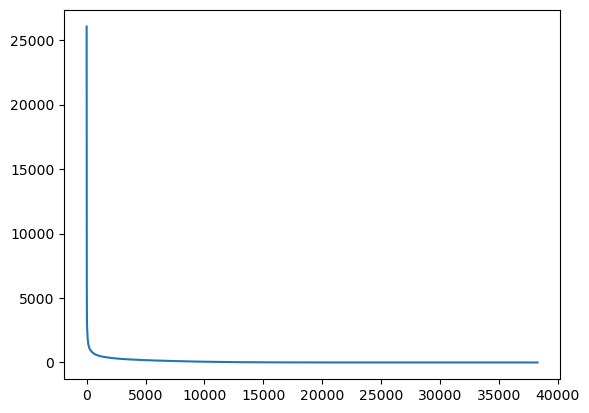

In [68]:
data_selection = np.argsort(-np.std(data, axis=1))
plt.plot(np.std(data, axis=1)[data_selection])
data = data[data_selection[:2000]]
gene_names = gene_names[data_selection[:2000]]
cov = np.cov(data)

In [70]:
gene_names[:10]

array(['"ENSMUSG00000064351"', '"ENSMUSG00000064339"',
       '"ENSMUSG00000064370"', '"ENSMUSG00000037742"',
       '"ENSMUSG00000023944"', '"ENSMUSG00000064341"',
       '"ENSMUSG00000029580"', '"ENSMUSG00000057113"',
       '"ENSMUSG00000020368"', '"ENSMUSG00000032399"'], dtype=object)

In [6]:
class SparsePCA(tf.keras.Model):
    """Sparse PCA convex relaxation for SGD.
    
    This equation was drafted based on eqs 19 and 20 in:
    https://arxiv.org/abs/2005.05195
    """
    
    def __init__(self, ndim, k):
        super(SparsePCA, self).__init__()
        self.ndim = ndim
        self.k = k
        self.z_weight = tf.Variable(tf.random.normal([self.ndim + 1]), name='z_weight')
        self.v_raw = tf.Variable(tf.random.normal([self.ndim]), name='v_raw')

    def call(self, inputs):
        # TODO: Properly constrain based on the off-diagonal entries
        # If z[i] > 0.5 (after scale by k) then impose a soft penalty that would come from z[j]/2 constraint
        z_value = tf.nn.softmax(self.z_weight)[:self.ndim] * self.k
        self.eigenvector = tf.tanh(self.v_raw) * z_value
        # PSD matrix of rank 1.
        self.proj_matrix = tf.matmul(tf.reshape(self.eigenvector, [self.ndim, 1]), tf.reshape(self.eigenvector, [1, self.ndim]))
        self.proj_matrix = self.proj_matrix / tf.linalg.trace(self.proj_matrix)
        # The paper uses elementwise multplication (Euclidean inner product).
        return tf.math.reduce_sum(inputs * self.proj_matrix)

In [62]:
model = SparsePCA(2000, 10)
optimizer = tf.keras.optimizers.Adam()
for nstep in range(1000):
    with tf.GradientTape() as tape:
        loss = -model(cov)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    if nstep % 10 == 9:
        print('loss: {}'.format(loss))

loss: -1173339.875
loss: -1272239.125
loss: -1416720.125
loss: -1673444.5
loss: -2120563.0
loss: -2813012.0
loss: -3784517.75
loss: -5054657.0
loss: -6634216.0
loss: -8528936.0
loss: -10741968.0
loss: -13275797.0
loss: -16134713.0
loss: -19325522.0
loss: -22854276.0
loss: -26723374.0
loss: -30932836.0
loss: -35482064.0
loss: -40369992.0
loss: -45593524.0
loss: -51146128.0
loss: -57017960.0
loss: -63196932.0
loss: -69669424.0
loss: -76420664.0
loss: -83434808.0
loss: -90695000.0
loss: -98184104.0
loss: -105885640.0
loss: -113785376.0
loss: -121872480.0
loss: -130140848.0
loss: -138589872.0
loss: -147224880.0
loss: -156057280.0
loss: -165104128.0
loss: -174386944.0
loss: -183929824.0
loss: -193757312.0
loss: -203892208.0
loss: -214353728.0
loss: -225156432.0
loss: -236310160.0
loss: -247820032.0
loss: -259686960.0
loss: -271908224.0
loss: -284478368.0
loss: -297389984.0
loss: -310634048.0
loss: -324200672.0
loss: -338079552.0
loss: -352260448.0
loss: -366733248.0
loss: -381489344.0
loss:

In [63]:
model.eigenvector

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([-0.01957751, -0.01720835, -0.04389084, ..., -0.00087085,
       -0.00036963, -0.00070458], dtype=float32)>

In [64]:
import numpy as np
np.linalg.norm(model.eigenvector.numpy())

0.10976157

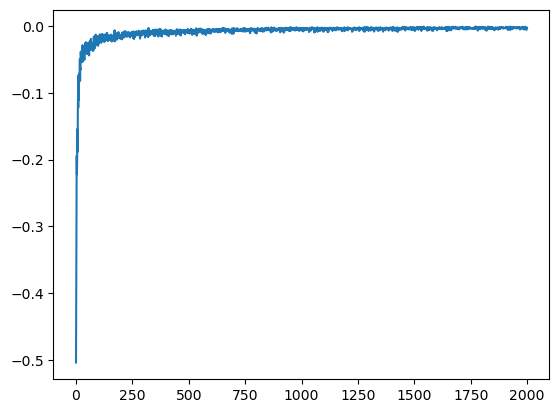

In [56]:
plt.plot(np.linalg.svd(cov)[0][:, 0])

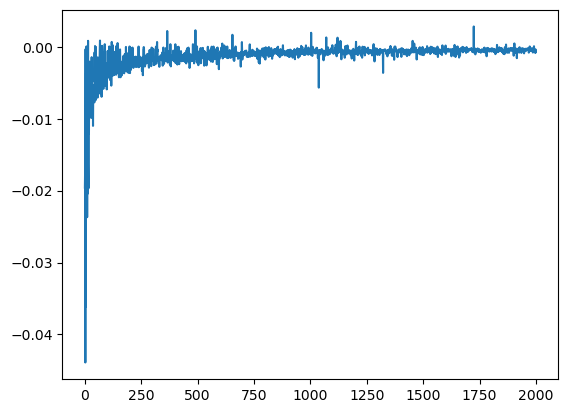

In [65]:
import matplotlib.pyplot as plt
plt.plot(model.eigenvector.numpy())

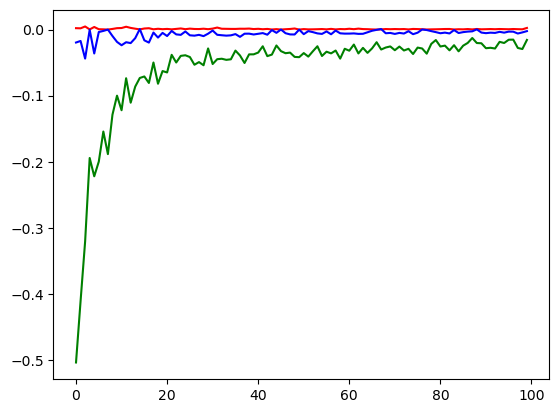

In [72]:
plt.figure()
plt.plot(tf.nn.softmax(model.z_weight).numpy()[:100], 'red')
plt.plot(model.eigenvector.numpy()[:100], 'blue')
plt.plot(np.linalg.svd(cov)[0][:100, 0], 'green')

In [60]:
np.quantile(tf.nn.softmax(model.z_weight).numpy(), [0.1, 0.5, 0.9, 0.999])

array([8.95169796e-05, 3.17926140e-04, 1.01452821e-03, 7.17756664e-03])

In [71]:
# ENSMUSG00000029012 -> Orc5
# https://cortecon.neuralsci.org/index.php?cort_mode=genedisplay&geneid=5001
gene_names[np.argsort(-model.z_weight)[:10]]

array(['"ENSMUSG00000029012"', '"ENSMUSG00000017716"',
       '"ENSMUSG00000064370"', '"ENSMUSG00000068823"',
       '"ENSMUSG00000000365"', '"ENSMUSG00000037710"',
       '"ENSMUSG00000023944"', '"ENSMUSG00000037795"',
       '"ENSMUSG00000055839"', '"ENSMUSG00000020235"'], dtype=object)